# Notebook demo de acousticfield

Esta es una notebook demo del paquete **acousticfield** de ((LAPSo))

## Requisitos

Si se instalo Anconda con el paquete base solo es necesario instalar por unica vez el paquete sounddevice con el comando

`%pip install sounddevice`

NOTA: Para windows este paquete viene sin soporte de ASIO. Para instalar con soporte de ASIO descargar el paquet de 
[https://download.lfd.uci.edu/pythonlibs/archived/sounddevice-0.4.4-pp38-pypy38_pp73-win_amd64.whl](https://download.lfd.uci.edu/pythonlibs/archived/sounddevice-0.4.4-pp38-pypy38_pp73-win_amd64.whl) e instalarlo con 

`%pip install sounddevice-0.4.4-pp38-pypy38_pp73-win_amd64.whl`

## Instalacion

La libreria **acousticfield** se puede instalar desde [https://test.pypi.org/project/acousticfield/](https://test.pypi.org/project/acousticfield/)

con el comando en una celda:

`%pip install -i https://test.pypi.org/simple/ acousticfield --no-deps`

el codigo fuente esta en 

[https://github.com/meguia/acousticfield](https://github.com/meguia/acousticfield)

Para instalar la ultima version directamente de github ejecutar en una celda

`%pip install  --force-reinstall "git+https://github.com/meguia/acousticfield"`


In [ ]:
# ATENCION solo ejecutar la primera vez!
#%pip install sounddevice
#%pip install  --force-reinstall "git+https://github.com/meguia/acousticfield"

# Importacion de librerias
Por ahora solo importamos sounddevice para chequear la configuracion de la interfaz de audio, y numpy porque lo que devuelve acousticfield en general son arrays numpy.

Todo lo de **acousticfield** lo importamos explicitamente de los diferentes submodulos:

- **generate** tiene funciones para generar sweeps y varios estimulos sencillos
- **io** funciones basicas para reproducir y grabar simultaneamente usando sounddevice
- **process** tiene funciones de DSP auxiliares, aca usamos de forma directa solo la que aplica el filtro inverso del sweep para extraer la RI
- **room** tiene una funcion principal para extraer parametros acusticos (paracoustic) 
- **display** es el modulo de mas alto nivel que devuelve graficos o tablas de parametros acusticos y graficas y resultados de estadisticas de la RI, espectro, espectrorgama, etc.


In [1]:
import numpy as np
import sounddevice as sd       
from acousticfield.generate import sweep, golay
from acousticfield.io import play_rec, play
from acousticfield.process import ir_extract,make_filterbank
from acousticfield.room import paracoustic
from acousticfield.display import *

# Ajuste de sounddevice
Elegir la interfaz de entrada salida si es necesario con sd.default_device[devicein,deviceout] usando los numeros que devuelve query_devices()

In [2]:
sd.query_devices()

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 iShowU Audio Capture, Core Audio (2 in, 2 out)
  3 ZoomAudioDevice, Core Audio (2 in, 2 out)

In [3]:
sd.default.device = [0,1]
fs = 48000

# Obtencion de la RI mediante Sweep Exponencial (tambien llamado logaritmico o LSS)
El sweep se puede generar una sola vez. los parametros son T (duracion en segundos) fs (frecuencia de sampleo), fi, f2 (frecuencia de inicio y final del sweep en Hz), la cantidad de repeticiones Nrep y filename el nombre del archivo. Ademas del sweep almacena el flitro inverso el tipo de estimulo 'sweep' y otra metadata en un archivo del mismo nombre .npz

In [4]:
sweep1 = sweep(T=10.0,fs=fs,f1=30,f2=22000,Nrep=1,filename='sweep_48kHz_10s_30_22k',post=1.0)

Warning RMS pedido mayor al RMS de corte que es -3.44 dB 
Sweep RMS = -3.44 dB 
Sweep generated with 528000 samples.
Total signal with 1 repetitions has a duration of 11.00 seconds


Grabacion del sweep. Los dos primeros parametros son el sweep a usar (siempre sin el .wav) y el nombre par ael archivo de alamacenamiento. Por defecto reproduce mono en canal 0 y graba mono en canal 0. Si se graba en mas de un canal o se usa un loopback hay que especificar los canales de salida (chanout) y de entrada (chanin). Devuelve la señal como numpy array 2D de (nsamples,nchannels). 

In [6]:
# descomentar para grabar una nueva respuesta impulso
# con loopback en el canal derecho
# rec_L1 = play_rec('sweep_48kHz_10s_30_22k','rec_L1',loopback=1,chanout=[0,1],chanin=[0,1])
# sin loopback
rec_L1 = play_rec('sweep_48kHz_10s_30_22k','rec_L1',loopback=1,chanout=[0],chanin=[0])

finished


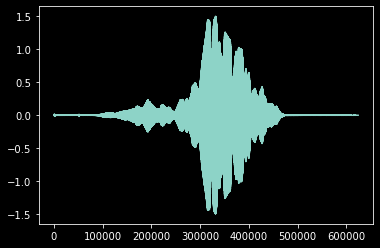

In [7]:
# Esto esta unicamente para chequear que no haya habido clipeo (agregar una funcion)
import matplotlib.pyplot as plt
plt.plot(rec_L1[:,0]) #solo para chequear que no haya saturado

## Extraccion de la respuesta impulso. 
Usamos `ir_extract` . 
El primer parametro puede ser el array o el nombre de archivo, el segundo es el filtro a usar (mismo nombre que el sweep) y el tercero es el nombre del archivo para almacenar la RI. Si uno de los canales se usa como loopback especificarlo en el parametro del mismo nombre. Si se pasa el array hay que especificar la frecuencia de sampleo (el default es 48 k). Devuelve un array numpy de (nsamples,nchannels) o (nsamples,nchannels-1) si se uso loopback. Almacena metadata en archivo con el mismo nombre de la ri .npz

In [8]:
# se puede partir de esta celda para chequear la notebook con una grabacion ya realizada 
# (si esta rec_L1.wav y sweep_48kHz_30_22k_inv.npz en el directorio)
ri_L1 = ir_extract('rec_L1','sweep_48kHz_10s_30_22k','ri_L1',fs=fs)

# Obtencion de la RI mediante Secuencias complementarias de Golay
Como metodo alternativo mas robusto frente a ruido podemos usar secuencias complementarias de Golay.
Los unicos parametros son el nombre del archivo, el orden de la secuencia (18 da una duracion aproximada del par complementario de 20 segundos) y la cantidad de repeticiones (aca la gracia es hacer varias porque el ruido es mas tolerable)
Tambien almacena las secuencias para invertir, el timpo de estimulo 'golay' y otra metadata en un archivo del mismo nombre .npz

In [16]:
golay('golay_x4_48k_N19',N=4, fs=fs, Nrep=2);

Golay complementary sequence generated with 32 samples each.
Total signal with 2 repetitions has a duration of 0.00 seconds


In [17]:
rec_L1_golay = play_rec('golay_x4_48k_N19','rec_L1_golay',chanout=[0],chanin=[0]) 

finished


In [18]:
ri_L1_golay = ir_extract('rec_L1_golay','golay_x4_48k_N19','ri_L1_golay',fs=fs)

# Respuesta impulso
Analisis de directo y reflexiones (ecos) y estadistica de la RI

Para graficar la IR y el directo detectado usamos **ir_plot** (puede graficar multicanal).

**echo_display** devuelve la lista de ecos en una tabla y en un grafico (atencion que por defecto hace una tabla y grafico por canal, si se quiere hacer de un canal en particular hay que pasarlo de forma explicita) El segundo parametro de echo_display es la cantidad de ecos a detectar nechoes (incluyendo el directo). Devuelve un array de dimensiones (nechoes,2,nchan) donde en la segunda dimension esta el tiempo y la intensidad de los ecos.

**irstats_plot** calcula la kurtosis y la fraccion normalizada de samples fuera de la desviacion estandar (stdexcess). Cuando la kurtosis se hace cercana a cero (medida de Fisher) o stdexcess se acerca a 1 se produce el cambio a una estadistica Gaussiana en la RI (mixing time). Grafica ambos valores y una linea vertical donde se ubica el mixing time para cada criterio. Tambien devuelve una medida de la desviacion estandar en dB (stdbup) por encima de la std minima (correspondiente al ruido de fondo) y un criterio para decidir que la RI ya alcanzo ese nivel es cuando esta 1dB por encima (tnoise). Grafica tambien stdbup y una linea vertical en el tiempo en el que se alcanza el ruido de fondo. Devuelve un diccionario con keys 'kurtosis' 'stdexcess' 'stdbup' 'mixing' y 'tnoise' con una fila por cada canal (tambien hace un grafico or canal si no se especifica uno en particular). 

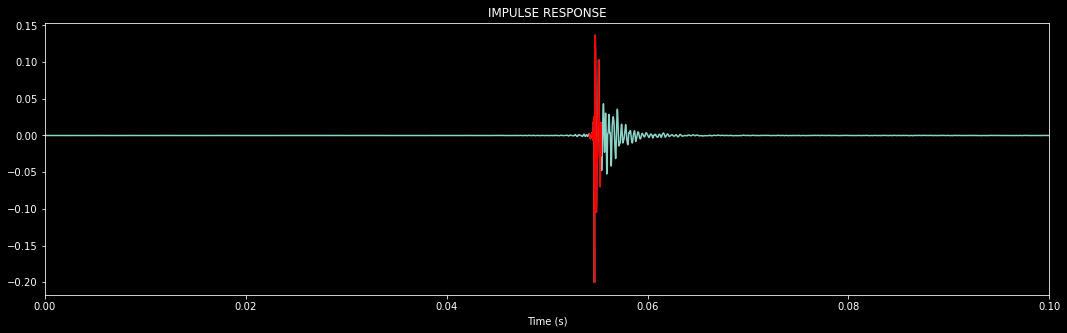

In [21]:
ir_plot(ri_L1,fs=fs,tmax=0.1)
#ir_plot(ri_L1_golay,fs=fs)
play(ri_L1,chanout=[0],normalized=True,fs=fs)

In [ ]:
echos = echo_display(ri_L1,7,fs=fs)

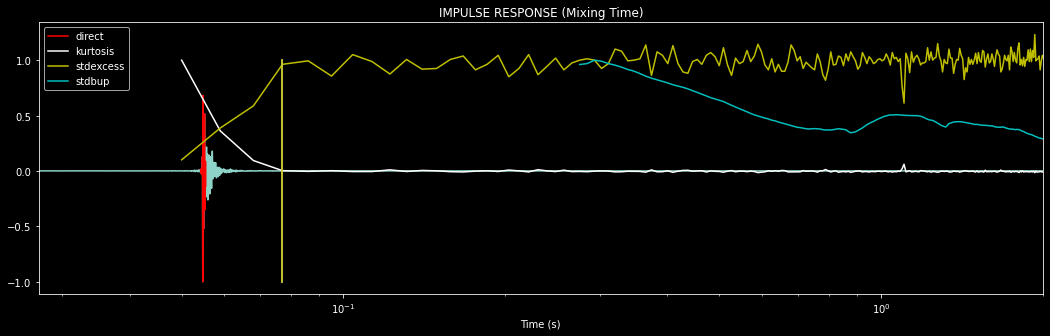

In [22]:
pstat = irstat_plot(ri_L1, window=0.01, overlap=0.001, logscale=True, fs=fs)
#pstat = irstat_plot(ri_L1_golay, window=0.01, overlap=0.001, logscale=True, fs=fs)

In [ ]:
ac = acorr_plot(ri_L1,trange=0.05,fs=fs)
ac = acorr_plot(ri_L1_golay,trange=0.05,fs=fs)

# Parametros acusticos

Calculo de los parametros acusticos usando paracoustic, el primer parametro es la RI (el array o el nombre de archivo), se puede especificarl el metodo para calcular el tiempo de reverberacion (rt30, rt20, rt15) y el banco de filtros a utilizar (el formato de nombre para el banco de filtros es fbank + frecuencia de sampleo + _ + numero de octavas + _ + numero de bandas por octavas. Por defecto el banco arranca en la octava de 62.5 para modificarlo se puede usar la funcion make_filterbank de process.

**paracoustic** devuelve un diccionario con todos los parametros por bandas, y dos columnas adicionales para ponderacion A y Flat. 

**pars_print** imprime todos los parametros (tambien se le puede pasar una lista de keys).

**pars_plot** hace graficos de los parametros que se le pasan como key.

Los parametros que se calculan son
- 'snr' relacion señal ruido en dB
- 'rt20' (o 'rt30' o 'rt15) tiempo de reverberacion en segundos
- 'edt' decaimiento temprano en segundos
- 'c50' y 'c80' claridad en dB con dos criterios
- 'ts' centro temporal en segundos
- 'dr' relacion directo reverberante en dB

Pero paracoustic tambien devuelve:
- 'rvalue' coeficiente de regresion del ajuste del decaimiento (puede incorporarse a parsprint)
- 'schr' integral de Schroeder para graficar el decaimiento
- 'lfit' 'tfit' intersecciones con tiempo y nivel donde realiza el ajuste de decaimiento

La funcion **parsdecay_plot** muestra los decaimientos por bandas en un multiplot.

En todos los casos muestra los datos de un solo canal (por defecto el canal 0 pero se puede especificar con el parametro chan)

In [23]:
#from acousticfield.process import make_filterbank
make_filterbank(fmin=62.5,noct=9,bwoct=1,fs=fs,bankname='fbank48k_9_1',show=True)

Banco de filtros generado: 9 octavas,1 bandas/octava,desde 62.5 Hz,Almacenada en archivo fbank48k_9_1


In [24]:
pars = paracoustic(ri_L1, method='rt20',bankname='fbank48k_9_1')

Using sample rate from filter bank:48000


In [25]:
pars_print(pars)

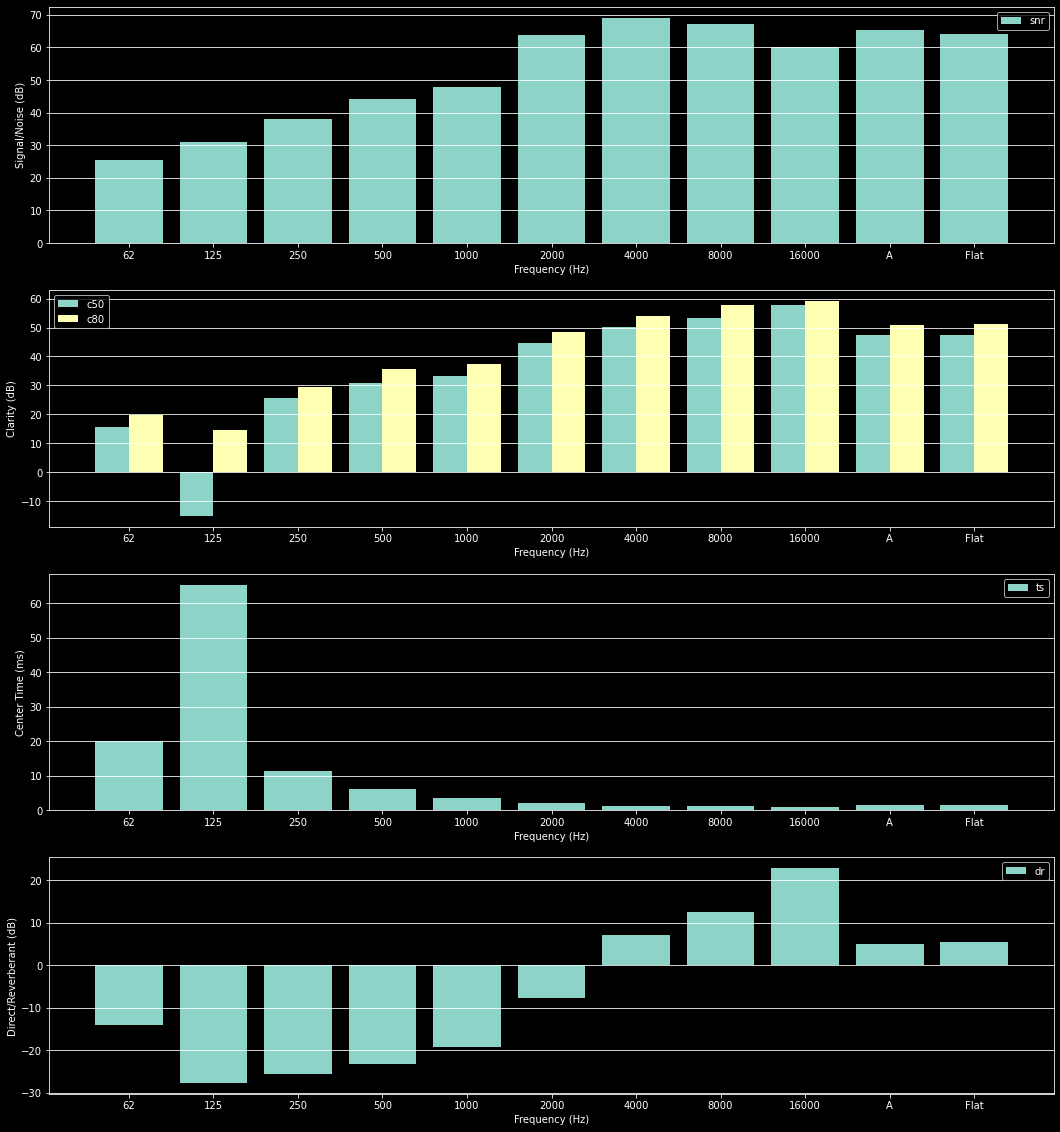

In [26]:
pars_plot(pars,['snr','rt30','c80','ts','dr'],chan=0)

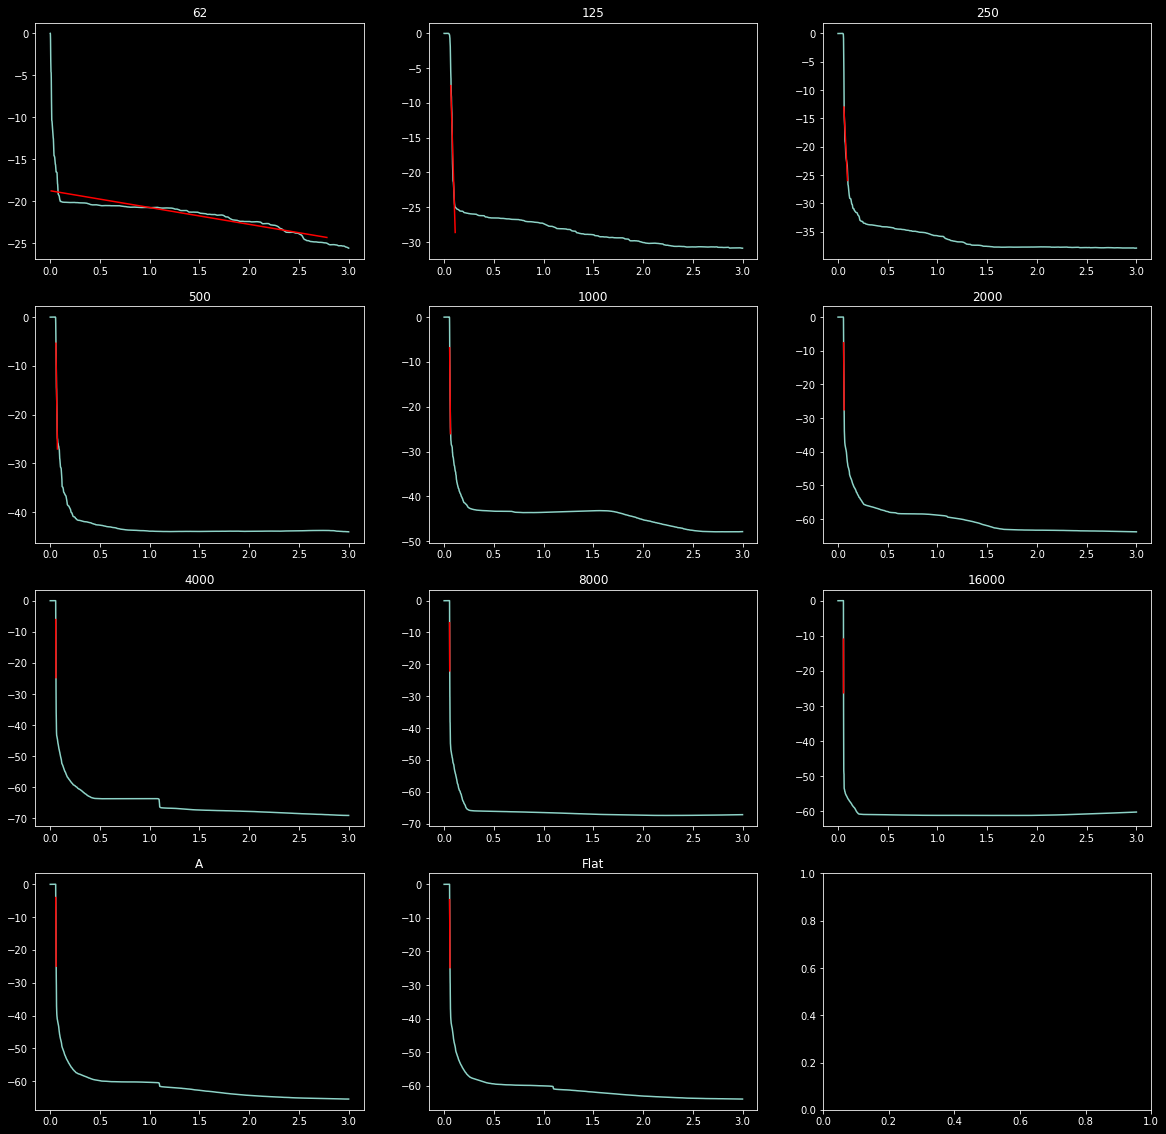

In [27]:
parsdecay_plot(pars,fs=fs)

In [ ]:
# Con Golay no llega a un SNR de 20 (esta grabado a baja intensidad)
pars_golay = paracoustic('ri_L1_golay', method='rt15',bankname='fbank48k_9_1')

In [ ]:
parsdecay_plot(pars_golay,fs=fs)

# Funcion Transferencia

La funcion **spectrum_plot** grafica y devuelve el espectro (power spectral density) y la fft como amplitud y fase de una señal arbitraria (multicanal)

Si pasamos la respuesta impulso como señal recibimos la funcion de transferencia. El primer parametro puede ser un array o un nombre de archivo. Si es array hay que especificar la frecuencia de sampleo. logscale se refiere a la escala de frecuencias (la magnitud esta en dB). fmax es la frecuencia maxima que muestra en el grafico pero calcula todo hasta Nyquist. Devuelve un diccionario con keys 'f' 's' 'amplitude' 'phase' correspondientes a la lista de frecuencias, y arrays 2D (un canal por fila) con el espectro de potencias, la amplitud y la fase de la fft respectivamente.
bajo

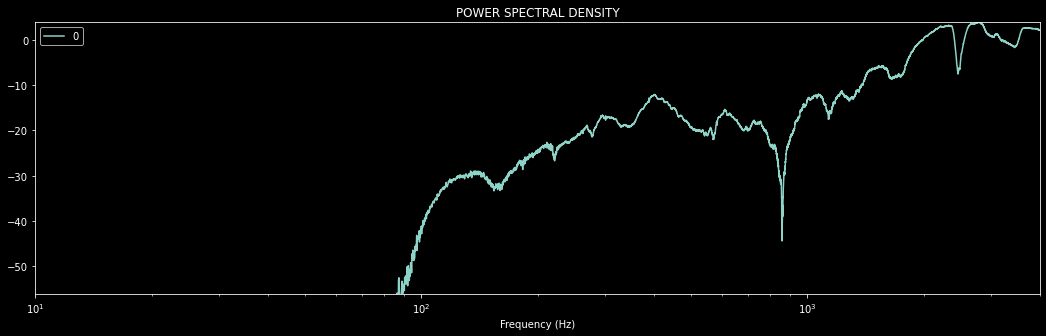

In [28]:
sp = spectrum_plot(ri_L1, logscale=True, fmax=4000, fs=fs)

# Espectrograma

Como en el caso anterior, **spectrogram_plot** grafica y devuelve el espectrograma (ahora de un solo canal que se puede especificar con el parametro chan). 
recibe como parametros ademas de la señal en primero lugar, el tamaño de ña ventana en samples 'window', el overlap de las ventanas en samples 'overlap' la frecuencia de sampleo y el rango en dB 'lrange'. 'normalize' = True normaliza la salida en amplitud.
Atencion, por ahora necesita el array (no el nombre de archivo)

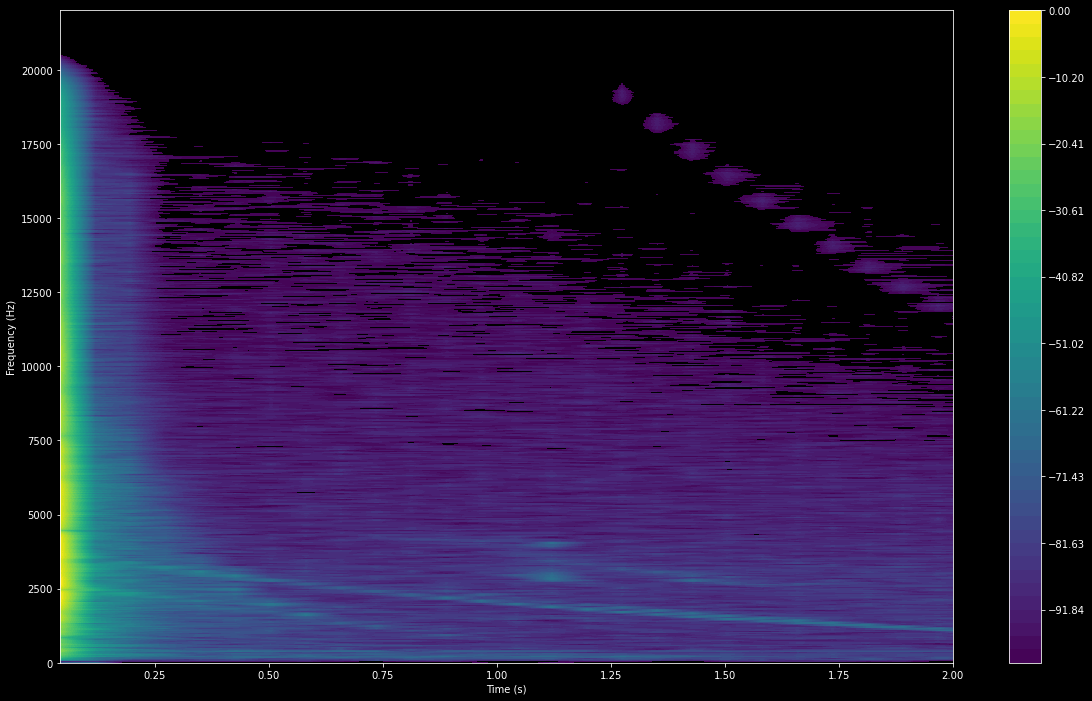

In [29]:
spec = spectrogram_plot(ri_L1,4096,400,chan=0,normalized=True,fs=fs,lrange=100,fmax=22000)